In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from csaps import CubicSmoothingSpline
from sklearn.metrics import r2_score
from scipy.ndimage.filters import gaussian_filter1d
import math
from scipy import stats

warnings.filterwarnings( 'ignore' )

pd.options.display.max_columns = None
pd.options.display.max_rows = None

species_color = {'Marmoset': "orange",'Human': "green",'Rhesus': "blue",'Chimpanzee': "red"}



PYTHON_PATH = "/Users/rb4174/Documents/projects/brain_dev_primates/altricial_brain_vocal_learning"


/var/folders/ys/4vmt6skn47v69q7dptm_7p3m0000gp/T/ipykernel_29551/2989880816.py:8: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


# Opening and preparing datasets

In [2]:
df = pd.read_excel("{0}/data/brain_growth_complete.xlsx".format(PYTHON_PATH),index_col=False)

df.loc[len(df.index) + 1] = [0,0,'Human',"Contour condition",0,0,0]
df.loc[len(df.index) + 1] = [0,0,'Chimpanzee',"Contour condition",0,0,0] 
df.loc[len(df.index) + 1] = [0,0,'Rhesus',"Contour condition",0,0,0] 
df.loc[len(df.index) + 1] = [0,0,'Marmoset',"Contour condition",0,0,0]
df = df[df.Species != "Capuchin"]


# Create events dicts

In [3]:
df_events = pd.read_excel("{0}/data/developmental_stages_events.xlsx".format(PYTHON_PATH))
df_events = df_events.dropna()
print(df_events["event"].unique())
df_events.head()

['dental_early_infancy_ends' 'dental_late_infancy_ends' 'gestation'
 'sexual_maturation_juvenile_end' 'weaning_complete']


,event_type,event,specie,min_wkspc,max_wkspc,avg_wkspc,avg_month_pc,sd_(days),original_format,original_description,data_reference
0,developmental_stages,dental_early_infancy_ends,Chimpanzee,84.142857,84.142857,84.142857,21.035714,0.0,"53.8 weeks, 12 months",ealy infancy = deciduous teeth last eruption,"Smith 2005, https://www.sciencedirect.com/scie..."
1,developmental_stages,dental_early_infancy_ends,Human,141.771429,141.771429,141.771429,35.442857,0.0,"108 weeks, 24 months",ealy infancy = deciduous teeth last eruption,"Smith 2005, https://www.sciencedirect.com/scie..."
2,developmental_stages,dental_early_infancy_ends,Marmoset,25.714286,25.714286,25.714286,6.428571,0.0,5 weeks,ealy infancy = deciduous teeth last eruption,"Smith 2005, https://www.sciencedirect.com/scie..."
3,developmental_stages,dental_early_infancy_ends,Rhesus,46.334914,46.334914,46.334914,11.583729,0.0,0.437 year,ealy infancy = deciduous teeth last eruption,"Smith 1994, Ages of Eruption of Primate Teeth:..."
4,developmental_stages,dental_early_infancy_ends,Capuchin,42.707371,42.707371,42.707371,10.676843,0.0,0.393 year,ealy infancy = deciduous teeth last eruption,"Smith 1994, Ages of Eruption of Primate Teeth:..."


In [4]:
gestation_periods,gestation_periods_sd,late_infancy_ends,early_infancy_ends,juvenile_ends = {},{},{},{},{}

for specie in df_events["specie"].unique():
    df_events_specie = df_events[(df_events.specie == specie)]
    gestation_periods[specie] = df_events_specie[(df_events_specie.event == "gestation")]["avg_wkspc"].values[0]
    gestation_periods_sd[specie] = df_events_specie[(df_events_specie.event == "gestation")]["sd_(days)"].values[0]/7
    early_infancy_ends[specie] = df_events_specie[(df_events_specie.event == "dental_early_infancy_ends")]["avg_wkspc"].values[0]
    late_infancy_ends[specie] = df_events_specie[(df_events_specie.event == "dental_late_infancy_ends")]["avg_wkspc"].values[0]
    juvenile_ends[specie] = df_events_specie[(df_events_specie.event == "sexual_maturation_juvenile_end")]["avg_wkspc"].values[0]

    
cut_period = {'Chimpanzee': 200, #'late_infancy': 187.34285714285713,
 'Human': 380, #'late_infancy': 348.1714285714285,
 'Marmoset': 60, #'late_infancy': 36.19428571428571
 'Rhesus': 100, #'late_infancy': 93.4457142857143
 }

# Sensitivity analysis

In [5]:
def sum_negative_diffs(x):
    """ Cumulative sum of the difference of decreasing consecutive values"""
    dx = np.diff(x)
    negative_diff = 0
    for i in dx:
        if i < 0:
            negative_diff += i
    
    return negative_diff


gestation_periods_plot, early_infancy_ends_plot, late_infancy_ends_plot = gestation_periods, early_infancy_ends, late_infancy_ends
NUMBER_OF_POINTS = 1000
FIT_VARIABLE = "weeks_post_conception" 


In [6]:
sensitivity_df = {"Species":[],"r2_score":[],"sum_non_monotonicity":[],"values":[],"x_values":[]}

x_each_specie = {}

for specie in df["Species"].unique():
    
    df_species_original = df[(df.Species == specie)&(df.weeks_post_conception < cut_period[specie])].sort_values(FIT_VARIABLE) # cut_period,late_infancy_ends
    df_species_original = df_species_original.groupby(FIT_VARIABLE, as_index=False).agg({'Species': 'first', 'data_origin': 'first', 'Adult_percent_brain_volume_cm3':"mean"})

    x_all_data = list(df_species_original[FIT_VARIABLE])
    y_all_data = list(df_species_original["Adult_percent_brain_volume_cm3"])

    df_specie = df_species_original
    df_specie = df_specie.sort_values(FIT_VARIABLE)
    
    x = list(df_specie[FIT_VARIABLE])
    y = list(df_specie["Adult_percent_brain_volume_cm3"])

    xi = np.arange(0,x[-1],(x[-1]-x[0])/NUMBER_OF_POINTS)
    x_each_specie[specie] = xi

    for smooth_parameter in [0.5,0.4,0.3,0.2,0.1,0.05,0.01,0.005,0.001]:
        for weights_0 in [1,0.75,0.5,0.25,0.1,0.05]:
            for weights_1 in [1,0.75,0.5,0.25,0.1,0.05]:
                for weights_2 in [1,0.75,0.5,0.25,0.1,0.05]:
                    for cut_date in [6,4,2,1,0,-1,-2,-4,-6]:

                        weights_before_birth = np.ones(len(df_specie[df_specie.weeks_post_conception <= gestation_periods_plot[specie] + cut_date]))
                        weights_before_early_ends = np.ones(len(df_specie[(df_specie.weeks_post_conception > gestation_periods_plot[specie] + cut_date)&(df_specie.weeks_post_conception <= early_infancy_ends_plot[specie])]))
                        weights_before_late_ends = np.ones(len(df_specie[(df_specie.weeks_post_conception > early_infancy_ends_plot[specie])]))

                        weights_species = {"Human": [weights_0,weights_1,weights_2], "Chimpanzee":[weights_0,weights_1,weights_2], "Rhesus": [weights_0,weights_1,weights_2],
                                            "Marmoset": [weights_0,weights_1,weights_2]}
                        weights_vector = np.concatenate([weights_before_birth*weights_species[specie][0], weights_before_early_ends*weights_species[specie][1],
                                                weights_before_late_ends*weights_species[specie][2]])
                        
                        s = CubicSmoothingSpline(x, y, weights=weights_vector,smooth=smooth_parameter,normalizedsmooth=False).spline
                        s.extrapolate = False

                        try:
                            sensitivity_df["r2_score"].append(r2_score(y_all_data,s(x_all_data)))
                            sensitivity_df["Species"].append(specie)
                            sensitivity_df["sum_non_monotonicity"].append(sum_negative_diffs(s(xi)))
                            sensitivity_df["values"].append(s(xi))
                            sensitivity_df["x_values"].append(x_each_specie[specie])
                        except:
                            pass

                    del(s)
sensitivity_df = pd.DataFrame(sensitivity_df)
sensitivity_df = sensitivity_df[sensitivity_df.r2_score > 0.92]
sensitivity_df.head()

,Species,r2_score,sum_non_monotonicity,values,x_values
0,Human,0.985708,-3.0192,"[1.1372711049477162e-05, 0.0004977786632770451...","[0.0, 0.3784285714285714, 0.7568571428571428, ..."
1,Human,0.985708,-3.0192,"[1.1372711049477162e-05, 0.0004977786632770451...","[0.0, 0.3784285714285714, 0.7568571428571428, ..."
2,Human,0.985708,-3.0192,"[1.1372711049477162e-05, 0.0004977786632770451...","[0.0, 0.3784285714285714, 0.7568571428571428, ..."
3,Human,0.985708,-3.0192,"[1.1372711049477162e-05, 0.0004977786632770451...","[0.0, 0.3784285714285714, 0.7568571428571428, ..."
4,Human,0.985708,-3.0192,"[1.1372711049477162e-05, 0.0004977786632770451...","[0.0, 0.3784285714285714, 0.7568571428571428, ..."


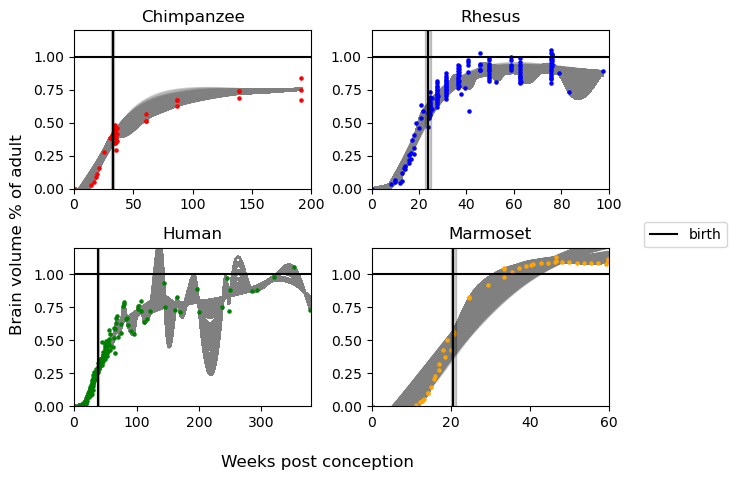

In [7]:
i = 0
fig, ax = plt.subplots(nrows=2, ncols=2)

species_list = ["Chimpanzee","Rhesus","Human","Marmoset"]

for row in ax:
    for col in row:
        try:
            specie = species_list[i]
            df_species = df[(df.Species == specie)]
            sensitivity_df_species = sensitivity_df[(sensitivity_df.Species == specie)]
            col.set_title(specie)
            
            for index, row in sensitivity_df_species.iterrows():
                col.plot(row["x_values"], row["values"], '-', color = "grey",alpha = 0.2,zorder = 0)
            col.scatter(df_species[FIT_VARIABLE],df_species["Adult_percent_brain_volume_cm3"],color = species_color[specie], marker = 'o', s =5)

            col.axvline(x = gestation_periods_plot[specie], color = "black",linestyle = '-',label="birth" if i == 0 else "")
            col.axvspan(gestation_periods[specie] - gestation_periods_sd[specie], gestation_periods[specie] + gestation_periods_sd[specie], alpha=0.2, color='black')

            col.axhline(y = 1, color = 'black')

            col.set_xlim(0,cut_period[specie])
            col.set_ylim(0,1.2)
            i += 1
        except:
            pass


fig.supxlabel('Weeks post conception') 
fig.supylabel('Brain volume % of adult')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
fig.savefig("{0}/figs/S1.pdf".format(PYTHON_PATH),dpi = 300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(0.92, 1.0)

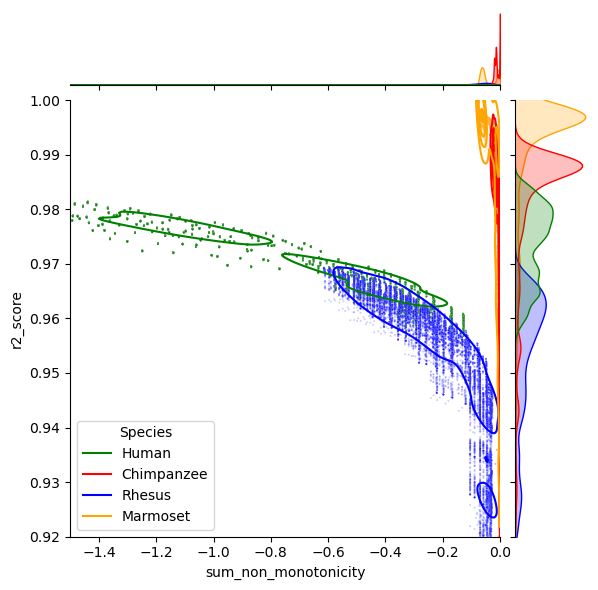

In [8]:
g = sns.jointplot(
    data=sensitivity_df,
    y="r2_score", x="sum_non_monotonicity", hue="Species",
    palette=["green","red","blue","orange"],alpha=.2,s=2)
g.plot_joint(sns.kdeplot,levels=5,common_norm=True)
g.savefig("{0}/figs/S2.pdf".format(PYTHON_PATH),dpi = 100)
g.savefig("{0}/figs/S2.eps".format(PYTHON_PATH),dpi = 100)
plt.xlim(-1.5,0)
plt.ylim(0.92,1)

Chimpanzee 15923
Rhesus 13527
Human 4698
Marmoset 14009


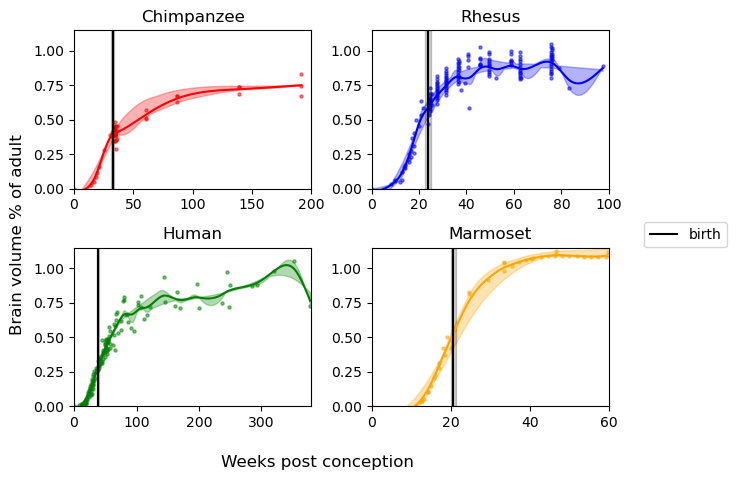

In [9]:
i = 0
average_fit,std_fit,max_fit,min_fit = {},{},{},{}
fig, ax = plt.subplots(nrows=2, ncols=2)
r2_species = {"Human": 0.95, "Chimpanzee":0.95, "Rhesus": 0.93, "Marmoset": 0.98}
nmono_species = {"Human": -0.5, "Chimpanzee":-0.5, "Rhesus": -0.5, "Marmoset": -0.5}

AVERAGE = "MEAN"
average_fit_list = [] 
all_derivatives_specie = {}
for row in ax:
    for col in row:
        try:
            specie = species_list[i]
            df_species = df[(df.Species == specie)]
            sensitivity_df_species = sensitivity_df[(sensitivity_df.Species == specie) & (sensitivity_df.sum_non_monotonicity > nmono_species[specie])
                                                    & (sensitivity_df.r2_score > r2_species[specie])]
            col.scatter(df_species[FIT_VARIABLE],df_species["Adult_percent_brain_volume_cm3"],color = species_color[specie], marker = 'o', s =5,alpha =0.5)
            col.set_title(specie)
            
            all_curves = []
            all_derivatives = []
            for index, row in sensitivity_df_species.iterrows():
                all_curves.append(row["values"])
                derivative = np.diff(row["values"])/np.diff(x_each_specie[specie])
                derivative[derivative<0] = 0 #substitute all really small negative values per zero
                all_derivatives.append(derivative/np.max(derivative))

            average_curve = np.mean(np.array(all_curves), axis=0)
            min_curve = np.min(np.array(all_curves), axis=0)
            max_curve = np.max(np.array(all_curves), axis=0)

            print(specie, len(sensitivity_df_species))

            col.plot(x_each_specie[specie], average_curve, '-', color = species_color[specie],alpha = 1)
            col.fill_between(x_each_specie[specie], min_curve,max_curve, color=species_color[specie], alpha=0.3)

            all_derivatives_specie[specie] = all_derivatives
            col.axvline(x = gestation_periods_plot[specie], color = "black",linestyle = '-',label="birth" if i == 0 else "")
            col.axvspan(gestation_periods[specie] - gestation_periods_sd[specie], gestation_periods[specie] + gestation_periods_sd[specie], alpha=0.2, color='black')

            col.set_xlim(0,cut_period[specie])
            col.set_ylim(0,1.15)
            i += 1
        except:
            pass

fig.supxlabel('Weeks post conception') 
fig.supylabel('Brain volume % of adult')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig("{0}/figs/S3.pdf".format(PYTHON_PATH),dpi = 300)
plt.tight_layout()
plt.show()

### Analysis of derivates lenght

In [10]:
all_species,all_derivatives, all_length_norm,all_length,all_percentiles = [],[],[],[],[]

mean_std = {}
for specie in all_derivatives_specie.keys():
    all_derivatives_length =[]
    percentiles = []
    for derivative in all_derivatives_specie[specie]:
        x = x_each_specie[specie][:-1]
        y = derivative
        distance = 0
        for count in range(1,len(y)):
            distance += math.sqrt(math.pow(x[count]-x[count-1],2) + math.pow(y[count]-y[count-1],2))
        all_derivatives_length.append(distance)
    for value in all_derivatives_length:
        percentiles.append(stats.percentileofscore(all_derivatives_length, value,kind="strict"))

    all_percentiles.extend(percentiles)
    all_species.extend([specie]*len(all_derivatives_length))
    all_length_norm.extend(all_derivatives_length/np.average(all_derivatives_length))
    mean_std[specie] = {"mean":np.mean(all_derivatives_length),"std":np.std(all_derivatives_length),"median":np.median(all_derivatives_length)}
    all_length.extend(all_derivatives_length)
    all_derivatives.extend(all_derivatives_specie[specie])

derivatives_df = pd.DataFrame({"species":all_species,"derivatives":all_derivatives,"length":all_length,"length_norm":all_length_norm,
                               "percentile":all_percentiles})

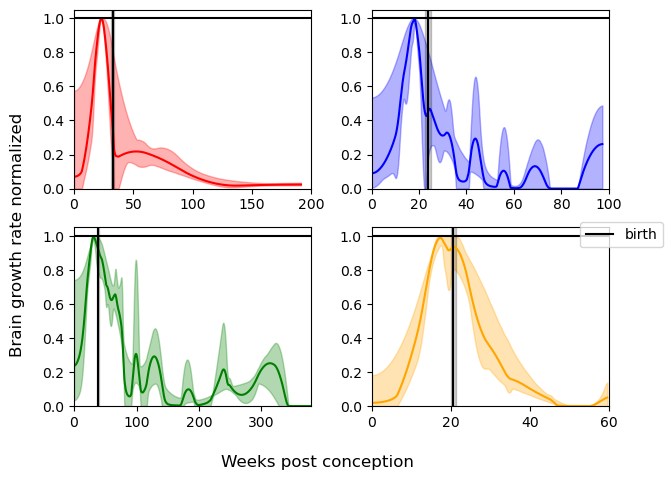

In [11]:
i = 0
derivative_data_species = {}
average_derivative = []
fig, ax = plt.subplots(nrows=2, ncols=2)
df_plot = {"specie":[],"x_dydx":[],"y_dydx":[],"y_dydx_low_95Percentil":[],"y_dydx_max_95Percentil":[]}

for row in ax:
    for col in row:
        specie = species_list[i]
        all_devs = list(derivatives_df[derivatives_df.species == specie]["derivatives"])

        average_derivative = np.mean(np.array(all_devs), axis=0)
        percentile2_5_derivative = np.percentile(np.array(all_devs),q = 2.5, axis=0)
        percentile97_5derivative = np.percentile(np.array(all_devs),q = 97.5, axis=0)

        low_95Percentil = gaussian_filter1d(percentile2_5_derivative,sigma = 1)
        max_95Percentil = gaussian_filter1d(percentile97_5derivative,sigma = 1)

        col.fill_between(x_each_specie[specie][:-1], low_95Percentil,max_95Percentil, color=species_color[specie], alpha=0.3)

        col.plot(x_each_specie[specie][:-1], average_derivative, '-', color = species_color[specie],alpha = 1)
        col.axvline(x = gestation_periods_plot[specie], color = "black",linestyle = '-',label="birth" if i == 0 else "")
        col.axvspan(gestation_periods[specie] - gestation_periods_sd[specie], gestation_periods[specie] + gestation_periods_sd[specie], alpha=0.2, color='black')
        col.axhline(y = 1, color = 'black')
        col.set_ylim(bottom=0)
        col.set_xlim(0,cut_period[specie])

        df_plot["specie"].append(specie)
        df_plot["x_dydx"].append(x_each_specie[specie][:-1])
        df_plot["y_dydx"].append(average_derivative)
        df_plot["y_dydx_low_95Percentil"].append(low_95Percentil)
        df_plot["y_dydx_max_95Percentil"].append(max_95Percentil)

        i += 1

fig.supxlabel('Weeks post conception') 
fig.supylabel('Brain growth rate normalized')
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
fig.tight_layout()
fig.savefig("{0}/figs/S4.pdf".format(PYTHON_PATH),dpi = 300)
plt.show()

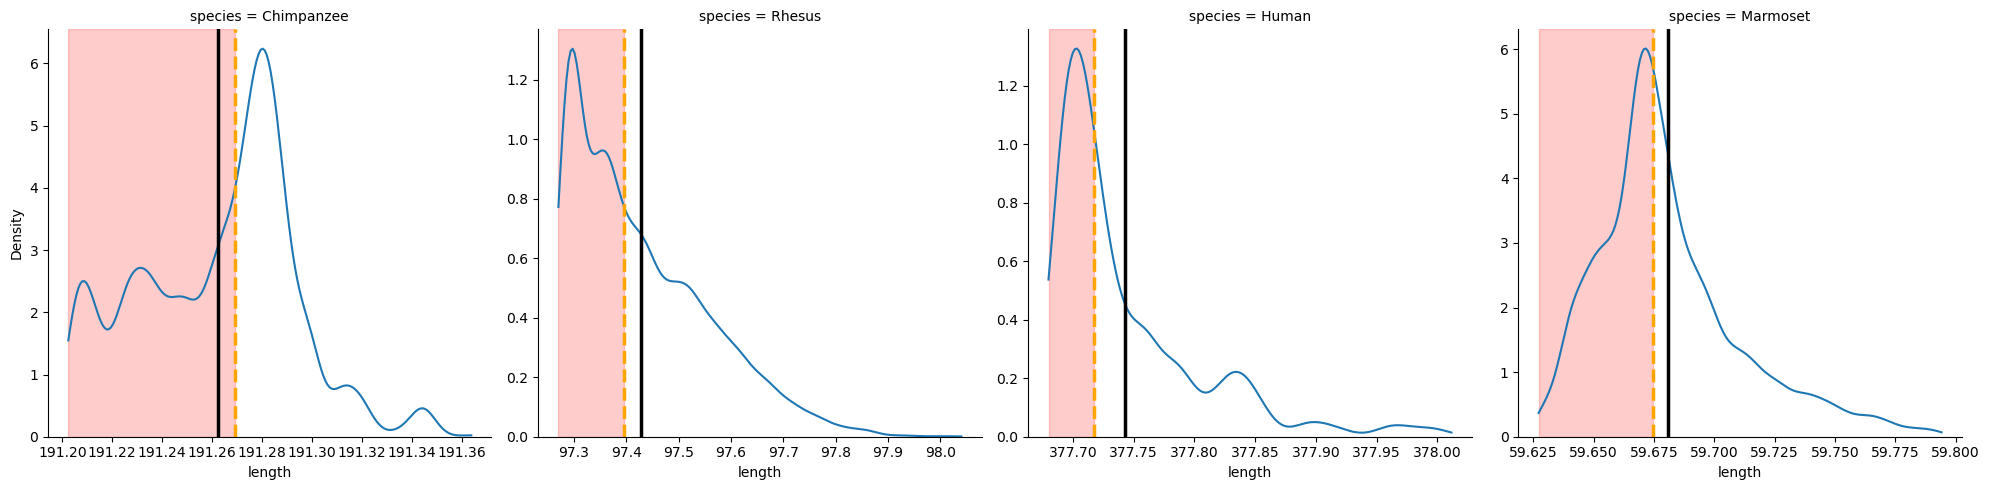

In [12]:
g = sns.displot(data=derivatives_df, x="length", col="species",cut = 0, kind="kde",facet_kws=dict(sharey=False,sharex=False))
axes = g.axes.flatten()

MIN_PERCENTIL_SPECIE = {"Human": 0, "Chimpanzee":0, "Rhesus": 0, "Marmoset": 0}
MAX_PERCENTIL_SPECIE = {"Human": 50, "Chimpanzee":50, "Rhesus": 50, "Marmoset": 50}

for ax in axes:
    # extract the species name
    spec = ax.get_title().split(' = ')[1]
    ax.axvline(x=mean_std[spec]['mean'], c='k', ls='-', lw=2.5)
    ax.axvline(x=mean_std[spec]['median'], c='orange', ls='--', lw=2.5)
    ax.axvspan(derivatives_df[(derivatives_df.species == spec)&(derivatives_df.percentile <= MIN_PERCENTIL_SPECIE[spec])]["length"].min(),
                derivatives_df[(derivatives_df.species == spec)&(derivatives_df.percentile <= MAX_PERCENTIL_SPECIE[spec])]["length"].max(), alpha=0.2, color='red')


g.savefig("{0}/figs/S5.pdf".format(PYTHON_PATH),dpi = 500)


## Definig derivative filters

In [13]:
derivatives_df_FILTERED = pd.DataFrame({"species":[],"derivatives":[],"length":[],"length_norm":[],"percentile":[]})

for species in derivatives_df["species"].unique():
    species_df = derivatives_df[(derivatives_df.percentile >= MIN_PERCENTIL_SPECIE[spec])
                                &(derivatives_df.percentile <= MAX_PERCENTIL_SPECIE[spec])
                                &(derivatives_df.species == species)]
    
    derivatives_df_FILTERED = pd.concat([derivatives_df_FILTERED,species_df],ignore_index=True)

for species in derivatives_df_FILTERED["species"].unique():
   all_derivatives_specie[species] = list(derivatives_df_FILTERED[(derivatives_df_FILTERED.species == species)]["derivatives"])


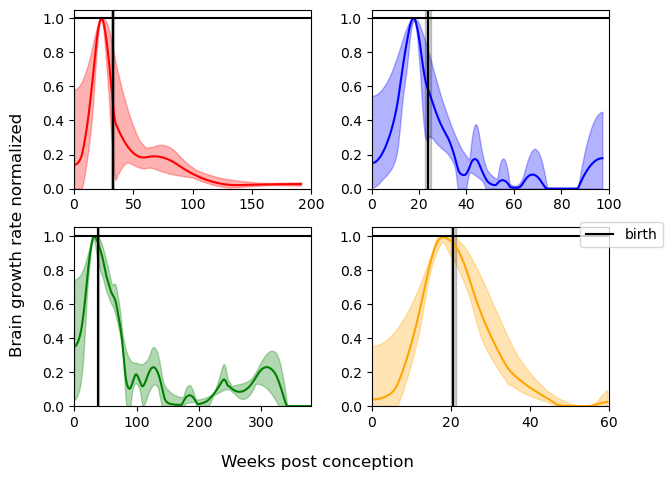

<Figure size 3000x5000 with 0 Axes>

In [14]:
i = 0
derivative_data_species = {}
average_derivative = []
fig, ax = plt.subplots(nrows=2, ncols=2)
plt.figure(figsize=(6, 10), dpi=500)
df_plot = {"specie":[],"N":[],"x_dydx":[],"y_dydx":[],"y_dydx_low_95Percentil":[],"y_dydx_max_95Percentil":[],"all_y":[]}

for row in ax:
    for col in row:
        specie = species_list[i]

        average_derivative = np.mean(np.array(all_derivatives_specie[specie]), axis=0)
        percentile2_5_derivative = np.percentile(np.array(all_derivatives_specie[specie]),q = 2.5, axis=0)
        percentile97_5derivative = np.percentile(np.array(all_derivatives_specie[specie]),q = 97.5, axis=0)

        low_95Percentil = gaussian_filter1d(percentile2_5_derivative,sigma = 1)
        max_95Percentil = gaussian_filter1d(percentile97_5derivative,sigma = 1)

        col.fill_between(x_each_specie[specie][:-1], low_95Percentil,max_95Percentil, color=species_color[specie], alpha=0.3)

        col.plot(x_each_specie[specie][:-1], average_derivative, '-', color = species_color[specie],alpha = 1)
        col.axvline(x = gestation_periods_plot[specie], color = "black",linestyle = '-',label="birth" if i == 0 else "")
        col.axvspan(gestation_periods[specie] - gestation_periods_sd[specie], gestation_periods[specie] + gestation_periods_sd[specie], alpha=0.2, color='black')
        col.axhline(y = 1, color = 'black')
        col.set_ylim(bottom=0)
        col.set_xlim(0,cut_period[specie])

        df_plot["specie"].append(specie)
        df_plot["N"].append(len(all_derivatives_specie[specie]))
        df_plot["x_dydx"].append(x_each_specie[specie][:-1])
        df_plot["y_dydx"].append(average_derivative)
        df_plot["y_dydx_low_95Percentil"].append(low_95Percentil)
        df_plot["y_dydx_max_95Percentil"].append(max_95Percentil)
        df_plot["all_y"].append(np.array(all_derivatives_specie[specie]))
        i += 1

df_plot = pd.DataFrame(df_plot)
df_plot.to_pickle("{0}/data/derivatives_with_error.pkl".format(PYTHON_PATH)) 

fig.supxlabel('Weeks post conception') 
fig.supylabel('Brain growth rate normalized')
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
fig.savefig("{0}/figs/S6.pdf".format(PYTHON_PATH),dpi = 300)
fig.tight_layout()
plt.show()